In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc
import APE_Calc as AC
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [5]:
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/'
tau = ['Extra/AC14restoring_KPP/3dayflat', 'Extra/AC14HF/3dayflat','3daynokpp']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']

# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)


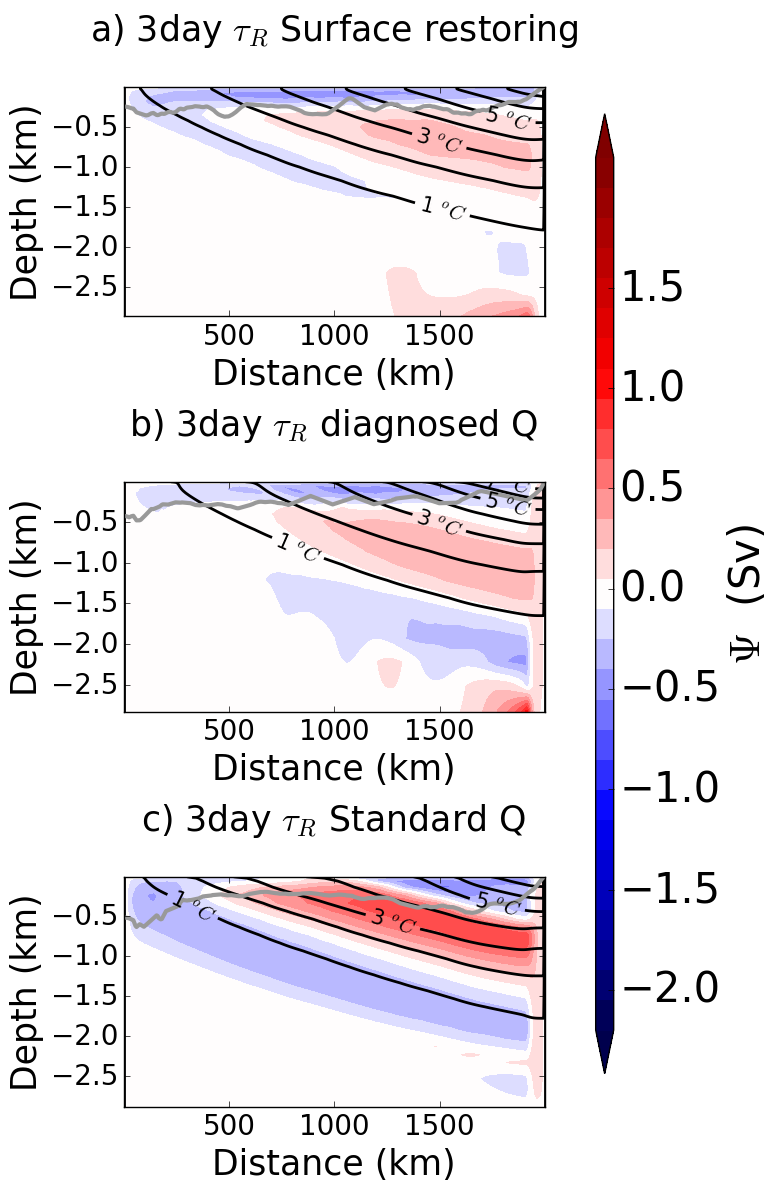

In [7]:
fig = plt.figure(figsize=(6.0, 12.))
# Create Panels
Psi_levs = np.arange(-2.25, 2.25, .15)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
layer_start = []
layer_fin = []
layer_med = []
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan   
    
    ax = fig.add_subplot(3, 1, i+1)
    # Make list of ROC / ROC0
    layer_start.append(c.get_zonal_avg('Tav.nc', 'THETA').min())
    layer_fin.append(c.get_zonal_avg('Tav.nc', 'THETA').max())
    layer_med.append(c.get_zonal_avg('Tav.nc', 'THETA').mean())
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    # Diabatic layer area
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer

    DDL = np.zeros(len(c.yc))
    DDL_matrix = np.zeros_like(Psi)
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(Psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<15 and depths[a-1,jj] - depths[a,jj] > 200:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]
        if DDL[jj]>2000:
            DDL[jj]= depths[4*a,jj]
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    if np.sum(mld.mean(axis=1))<np.sum(DDL):
        DDL = mld.mean(axis=1)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    if np.sum(mld.mean(axis=1))<np.sum(DDL):
        DDL = mld.mean(axis=1)
    r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.60', linewidth=3)
    #r2 = ax.plot(c.yc/1000,SG.savitzky_golay(-mld.mean(axis=1)/1000,21,1),scalex=False,scaley=False, color='0.60', linewidth=3)
    #r = ax.contour(c.yg[10:-10]/1000, c.zc/1000, np.apply_along_axis(SG.savitzky_golay,1,PIz,17,1)[:,10:-10], [1-(0.5*10**-5)],
     #              colors='0.75', linewidths=2)
    if str(Figletter[Runs[i]])=='a) ':
        ax.set_title(str(Figletter[Runs[i]])+r'3day $ \tau _{R} $ Surface restoring' +'\n', fontsize=25)
    elif str(Figletter[Runs[i]])=='b) ':
        ax.set_title(str(Figletter[Runs[i]])+r'3day $ \tau _R $ diagnosed Q' +' \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='c) ':
        ax.set_title(str(Figletter[Runs[i]])+r'3day $ \tau _R $ Standard Q ' +'\n', fontsize=25)

    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

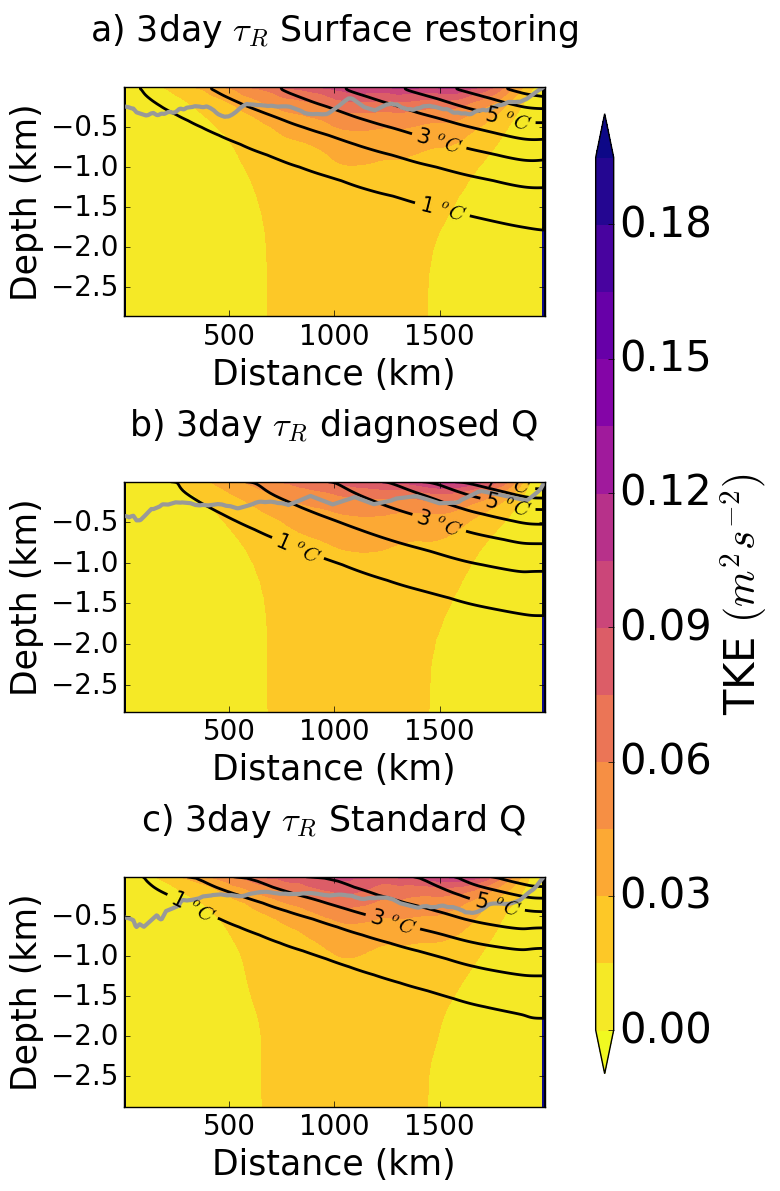

In [10]:
fig = plt.figure(figsize=(6.0, 12.))
# Create Panels

Psi_levs = np.arange(-0., .2, .015)

Psi_ticks =np.arange(-0., .2, .03)


Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
layer_start = []
layer_fin = []
layer_med = []
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    TKE = c.calc_MKE()+c.calc_EKE()
    TKE=TKE.filled(TKE[-2])
    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan   
    
    ax = fig.add_subplot(3, 1, i+1)
    # Make list of ROC / ROC0
    layer_start.append(c.get_zonal_avg('Tav.nc', 'THETA').min())
    layer_fin.append(c.get_zonal_avg('Tav.nc', 'THETA').max())
    layer_med.append(c.get_zonal_avg('Tav.nc', 'THETA').mean())
    p = ax.contourf(c.yc/1000, c.zc/1000,
                TKE,Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    # Diabatic layer area
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer

    DDL = np.zeros(len(c.yc))
    DDL_matrix = np.zeros_like(Psi)
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(Psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<15 and depths[a-1,jj] - depths[a,jj] > 200:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]
        if DDL[jj]>2000:
            DDL[jj]= depths[4*a,jj]
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    if np.sum(mld.mean(axis=1))<np.sum(DDL):
        DDL = mld.mean(axis=1)
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    if np.sum(mld.mean(axis=1))<np.sum(DDL):
        DDL = mld.mean(axis=1)
    r = ax.plot(c.yc/1000,SG.savitzky_golay(-DDL/1000,21,1),scalex=False,scaley=False, color='0.60', linewidth=3)
    #r2 = ax.plot(c.yc/1000,SG.savitzky_golay(-mld.mean(axis=1)/1000,21,1),scalex=False,scaley=False, color='0.60', linewidth=3)
    #r = ax.contour(c.yg[10:-10]/1000, c.zc/1000, np.apply_along_axis(SG.savitzky_golay,1,PIz,17,1)[:,10:-10], [1-(0.5*10**-5)],
     #              colors='0.75', linewidths=2)
    if str(Figletter[Runs[i]])=='a) ':
        ax.set_title(str(Figletter[Runs[i]])+r'3day $ \tau _{R} $ Surface restoring' +'\n', fontsize=25)
    elif str(Figletter[Runs[i]])=='b) ':
        ax.set_title(str(Figletter[Runs[i]])+r'3day $ \tau _R $ diagnosed Q' +' \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='c) ':
        ax.set_title(str(Figletter[Runs[i]])+r'3day $ \tau _R $ Standard Q ' +'\n', fontsize=25)

    ax.set_xlabel('Distance (km)', fontsize=25)
    ax.set_ylabel('Depth (km)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('TKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

In [120]:
fig = plt.figure(figsize=(18.5, 16.5))
# Create Panels
Psi_levs = np.arange(-2.2, 2.25, .15)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
layer_start = []
layer_fin = []
layer_med = []

for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan
    ax = fig.add_subplot(1, 1, i+1)
    # Make list of ROC / ROC0
    layer_start.append(c.get_zonal_avg('Tav.nc', 'THETA').min())
    layer_fin.append(c.get_zonal_avg('Tav.nc', 'THETA').max())
    layer_med.append(c.get_zonal_avg('Tav.nc', 'THETA').mean())
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    r = ax.contour(c.yg/1000,c.zc/1000, PIz,[0.999], colors='0.75', linewidths=3)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'0 day, Surface restoring \n', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

IOError: /noc/msm/scratch/students/hb1g13/Mobilis//Extra/AC14restoring_KPP/3dayflatdayflat//Temp not found.

In [121]:
# Generate layers
# Select run
i = 0
# Tell me the run I've selected
print tau[i],'m'
# Parameters from output adjust to ensure all layers are fully captured
bot = math.floor(layer_start[i]) # Round down
top = math.ceil(layer_fin[i]) # Round up
med = np.round(np.round(layer_med[i],1))
# High resolution for the layers of interest!
layers = np.arange(med-1.0,med+1.0, 0.1)
# Fill in the layers from low temps to layers of interest
layers1 = np.linspace(bot,layers[0],12)
# Fill in the layers from layers of interest to the maximum temperature
layers2 = np.linspace(layers[-1],top,12)
# Concatonate 
layers_data = layers1[0:-1].tolist() + layers.tolist() + layers2[1::].tolist()
layers_data.append(top+0.2)
# Adjust for temperature skews
# If layers of interest encompass the bottom value
if med-1 <= bot: 
    # Fill in only the layers of interest to the maximum temperature
    layers2 = np.linspace(layers[-1],top,23)
    layers_data = layers.tolist() + layers2[1::].tolist() 
    layers_data.append(top+0.2)
# If layers of interest are far hotter than the bottom value
elif abs(bot-(med-1))<2.4 :
    # Take less lower values
    layers1 = np.linspace(bot,layers[0],10)
    # And more higher values
    layers2 = np.linspace(layers[-1],top,14)
    layers_data = layers1[0:-1].tolist() + layers.tolist() + layers2[1::].tolist() 
# Neaten it up
layers_data_final = np.round(layers_data,2)
layers_data.append(top+0.2)
# Commma separate it.
print ",".join(map(str,layers_data_final))

Extra/AC14restoring_KPP/3dayflat m


IndexError: list index out of range

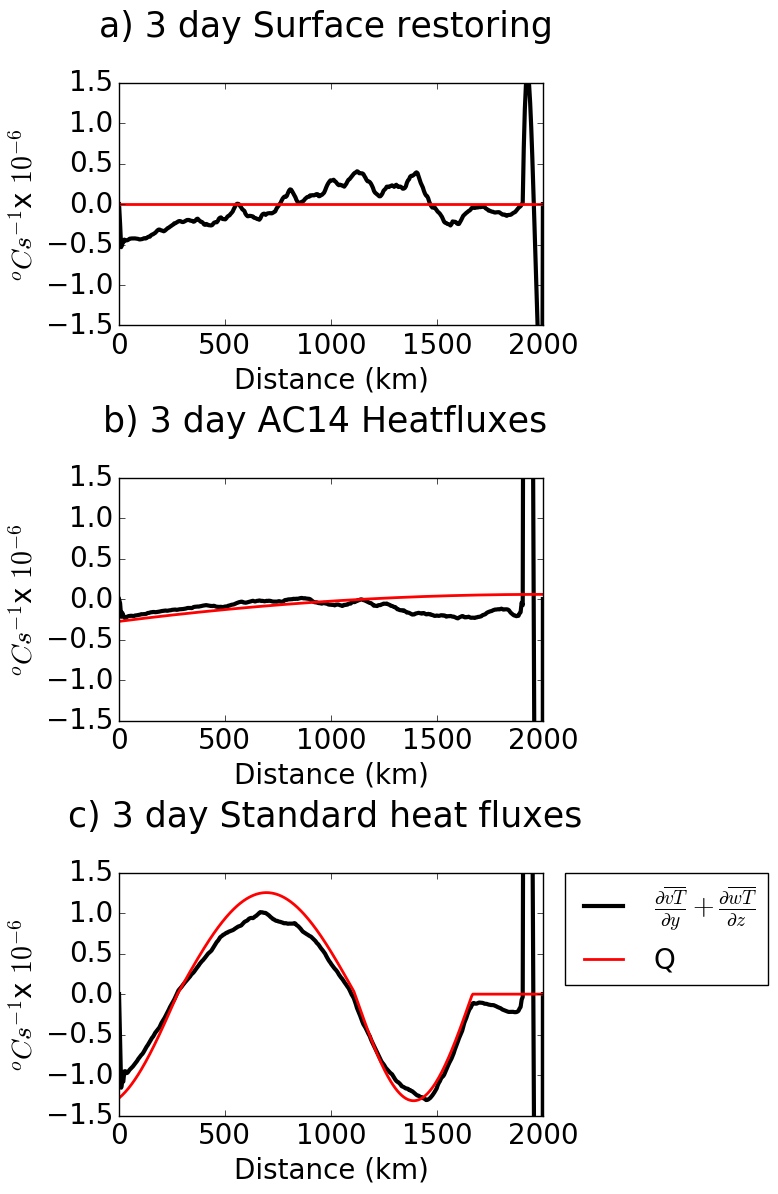

In [122]:
fig = plt.figure(figsize=(6.0, 12.))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))

    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # put everything on the C Grid                    
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVT = (VT[:,0:-1,:]-VT[:,1::,:])*CellVol
    dWT = (WT[1::,:,:]-WT[0:-1,:,:])*CellVol[0:-1,:,:]
    Adv = (dVT.sum(axis=0) + dWT.sum(axis=0))/sum(CellVol)
    Diff = -(5000*(dVT.sum(axis=0) + dWT.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Q = c.mnc('SURF.nc', 'TFLUX').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(3, 1, i+1)
    p = ax.plot(c.yc/1000,(Diff+Surcor)*(1000*3985),'k',linewidth=3)
    p = ax.plot(c.yc/1000,(Psipred/2)*10**6,'r',linewidth=2)
    ax.set_ylim(-1.5,1.5)
    #r = ax.contour(c.yg/1000,c.zc/1000, PIz,[0.999], colors='0.75', linewidths=3)
    if str(Figletter[Runs[i]])=='a) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='b) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='c) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Standard heat fluxes \n', fontsize=25)


    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)

lgd=plt.legend([r'$\frac{\partial  \overline{vT}}{\partial y} + \frac{\partial  \overline{wT}}{\partial z}$',
                'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

In [171]:
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/'

tau = ['Extra/AC14restoring_KPP/3dayflat', 'Extra/AC14restoring_KPP_closed/3dayflat','Extra/AC14HF/3dayflat','Extra/AC14HF_closed/3dayflat','3daynokpp','Closeddaynokpp']
Figletter = ['a) ','b) ','c) ','d) ','e) ','f) ','g)','h)','j)']

# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


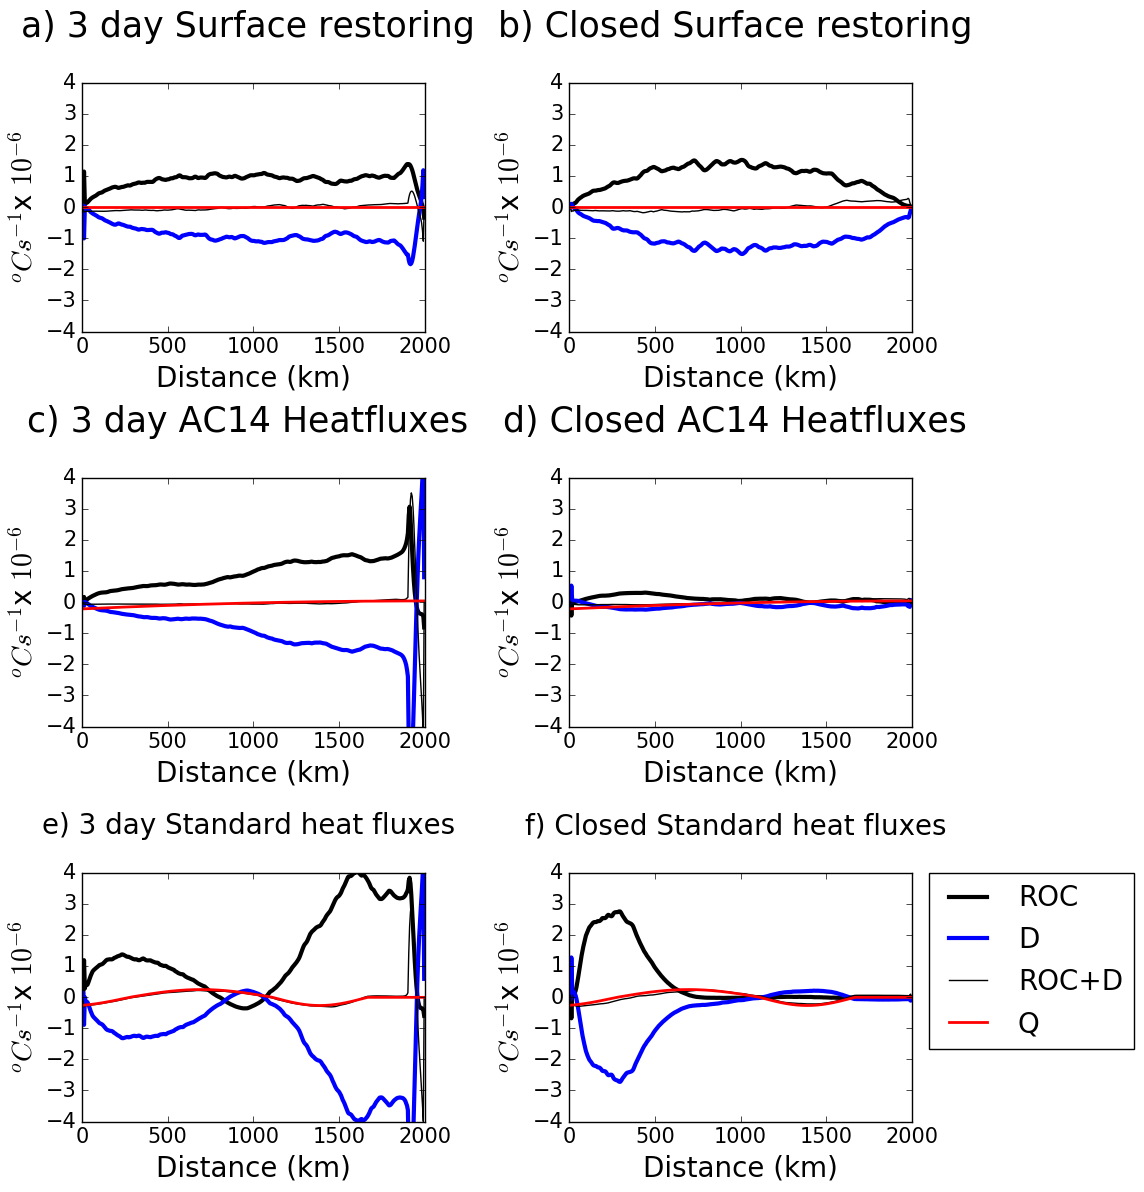

In [59]:
fig = plt.figure(figsize=(10.0, 12.))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))

    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # put everything on the C Grid                    
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Surface cor
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
   

    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.sum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    #25 = 5000/200
    dx = 5000
    nx = 200
    Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).mean(axis=2)/nx - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/dx)
    Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).mean(axis=2)/nx - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/dx)
    Q = c.mnc('SURF.nc', 'TFLUX').mean(axis=0).mean(axis=1)
    D = -np.sum((Dz+Dy)/np.sum(CellVol.mean(axis=2)),axis=0)
    Psipred = -(Q)/(1000*3985)

    ax = fig.add_subplot(3, 2, i+1)

    p = plt.plot(c.yc/1000,-ROC*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(-D+ROC+Surcor)*10**6,'k',linewidth=1)
    p = plt.plot(c.yc/1000,(-Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    if str(Figletter[Runs[i]])=='a) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='b) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='c) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='d) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='e) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Standard heat fluxes \n', fontsize=20)
    elif str(Figletter[Runs[i]])=='f) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed Standard heat fluxes \n', fontsize=20)
    
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
lgd = plt.legend([r'ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


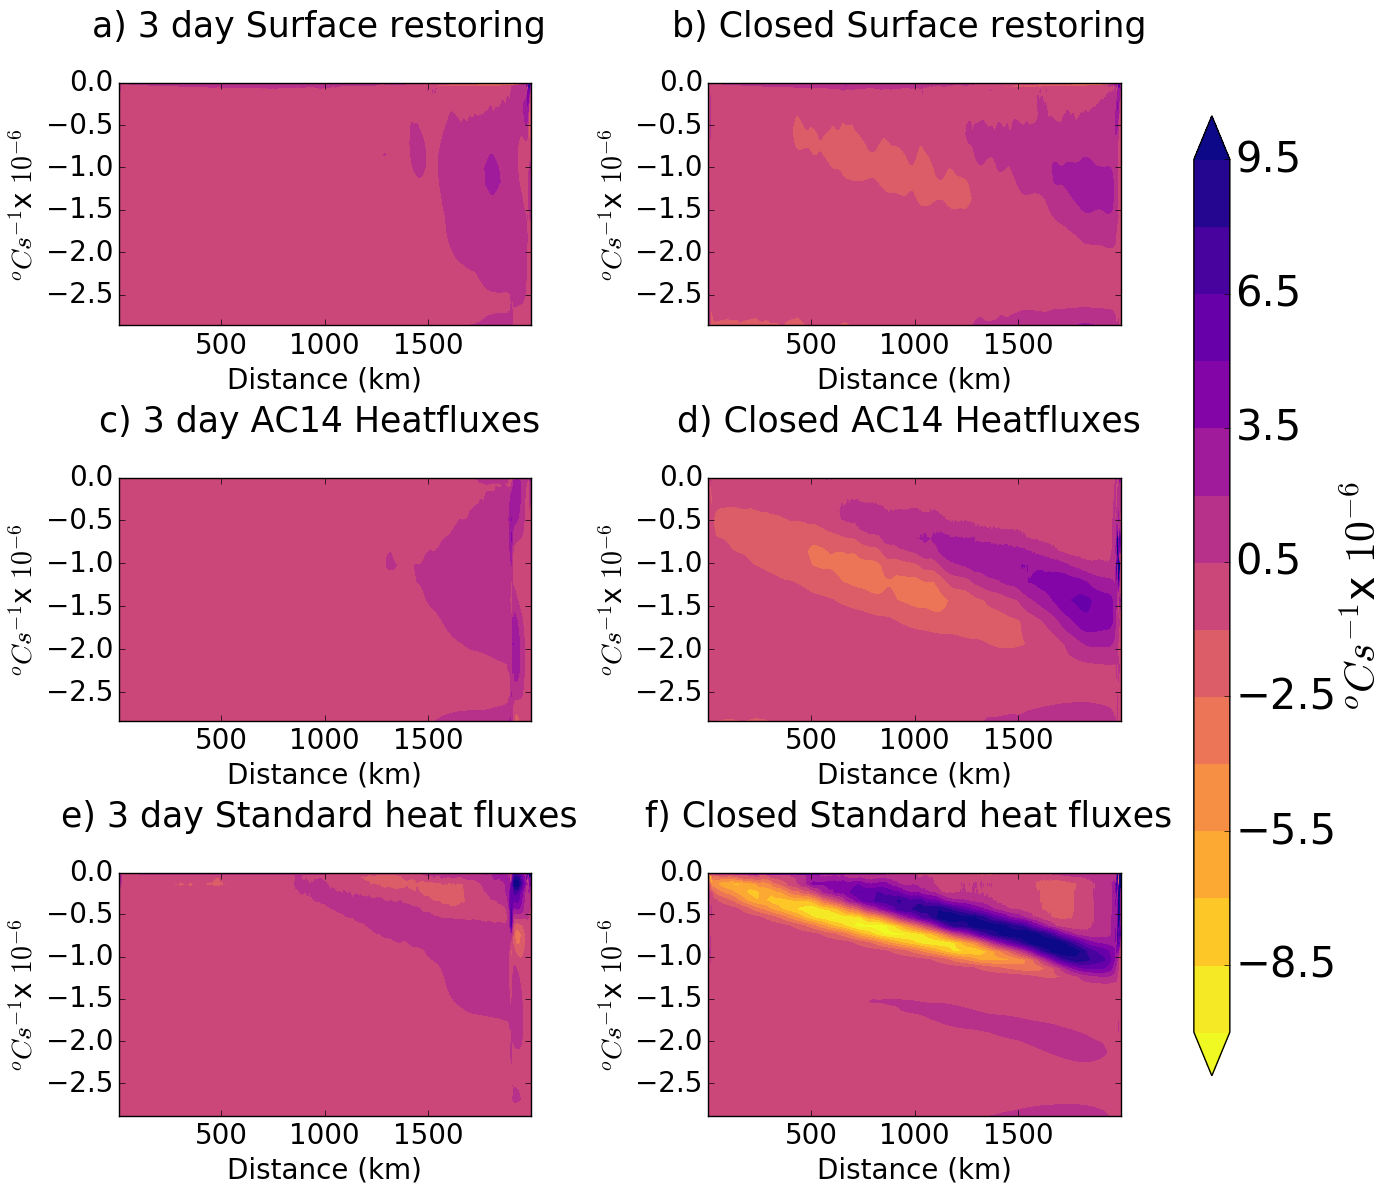

In [57]:
fig = plt.figure(figsize=(12.0, 12.))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))

    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar         
    # put everything on the C Grid                    
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Surface cor
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
   
    ax = fig.add_subplot(3, 2, i+1)
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.cumsum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    Dz = ((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).sum(axis=2) - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    Dy = ((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).sum(axis=2) - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    
    D = (Dz+Dy)/np.sum(CellVol.mean(axis=2))
 
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**6, np.arange(-1,1,0.15)*10, cmap=plt.cm.plasma_r, extend='both')

    if str(Figletter[Runs[i]])=='a) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='b) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='c) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='d) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='e) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Standard heat fluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='f) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed Standard heat fluxes \n', fontsize=25)
    
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

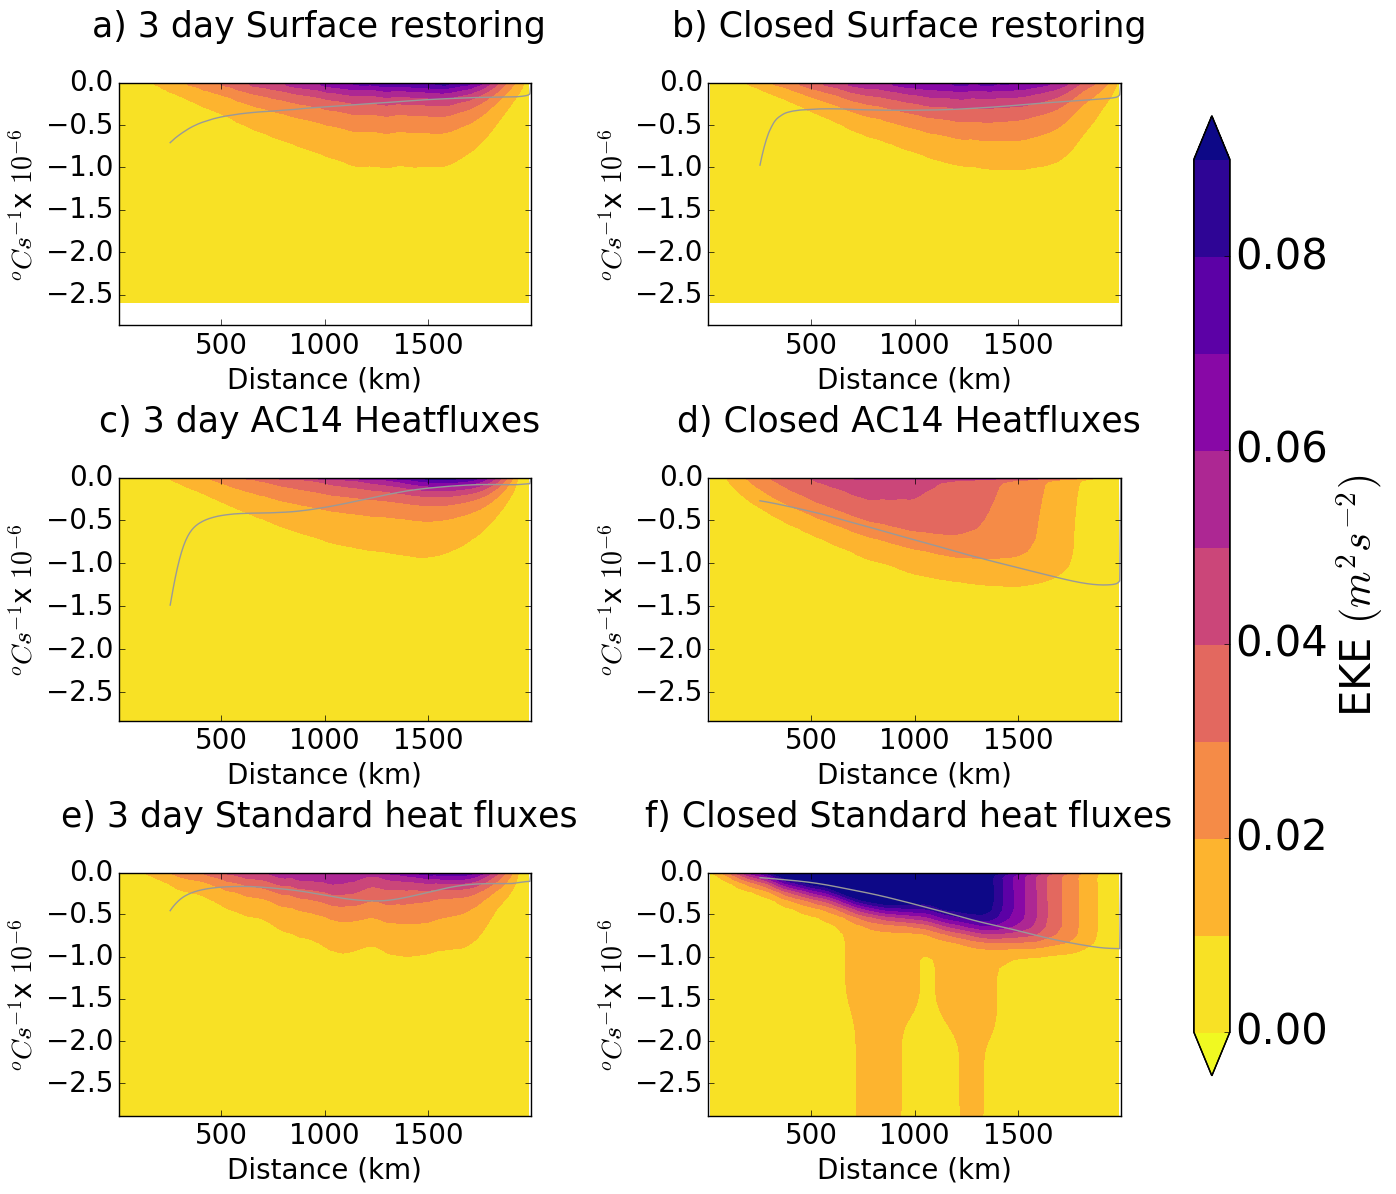

In [29]:
fig = plt.figure(figsize=(12.0, 12.))
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    EKE = c.calc_EKE()
    EKE[EKE==np.nan]=0
    ax = fig.add_subplot(3, 2, i+1)
   
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    EKE, Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI, PI < 0.95)
    # Depths
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1], axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    r = ax.plot(c.yc[50::]/1000,-mld.mean(axis=1)[50::]/1000,scalex=False,scaley=False, color='0.60', linewidth=1)
    
    if str(Figletter[Runs[i]])=='a) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='b) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed Surface restoring \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='c) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='d) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed AC14 Heatfluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='e) ':
        ax.set_title(str(Figletter[Runs[i]])+'3 day Standard heat fluxes \n', fontsize=25)
    elif str(Figletter[Runs[i]])=='f) ':
        ax.set_title(str(Figletter[Runs[i]])+'Closed Standard heat fluxes \n', fontsize=25)
    
    ax.set_xlabel('Distance (km)', fontsize=20)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)


In [182]:
Dsum = []
Vsum = []
Darea = []
APEt = []
mldinc = []
avdl = []
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
 
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.sum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2)/5000)
    
    # Diabatic eddis from new def
    dx = 5000
    nx = 200
    Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).mean(axis=2)/nx - dPz
    Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).mean(axis=2)/nx - dPy
    D = np.cumsum(abs(Dy),axis=1)
    # Diabatic layer area
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc))
    DDL_matrix = np.zeros_like(psi)
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(Psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<15 and depths[a-1,jj] - depths[a,jj] > 200:
            DDL[jj] = (depths[a-1,jj]+depths[a+1,jj])/2
        else:
            DDL[jj] = depths[a,jj]
        if DDL[jj]>1200 and a<20:
            DDL[jj]= depths[a+10,jj]

    #mld = c.mnc('MLD.nc','MXLDEPTH')[0,:,:]
    #if np.sum(mld.mean(axis=1))<np.sum(DDL):
    #    DDL = mld.mean(axis=1)
    # Diabatic area mask
    Zmatrix = np.tile(c.zc,(c.Ny,1)).T
    for jj in range(c.Ny):
        Zval = -Zmatrix[:,jj]
        Zmatrix[Zval>DDL[jj],jj] = 0
        #Zmatrix[Zval<=DDL[jj],jj] = 1
    V = c.calc_EKE()
    g = AC.APEcomputer(c)
    APE = g.calc_APE()

    
    mld = np.sum(np.mean(c.mnc('MLD.nc','MXLDEPTH')[0,30::,:],axis=1))
    
    incD = (np.sum(D))#/D0
    incV = (np.sum(abs(V)*CellVol.mean(axis=2)))#/V0
    incDdl = (np.sum(DDL))#/DDL0
    incAPE = (np.sum(APE.mean(axis=1)))#/APE0
    Dsum.append(incD)
    Vsum.append(incV)
    Darea.append(incDdl)
    APEt.append(incAPE)
    mldinc.append(mld)
    avdl.append((abs(mld)+abs(incDdl))/2.0)
Dsum = np.array(Dsum)
Vsum = np.array(Vsum)
Darea = np.array(Darea)
APEt = np.array(APEt)
mldinc = np.array(mldinc)
dlinc =  np.array(avdl)

In [183]:
Dsum3day=Dsum[::2]
Dsumclosed=Dsum[1::2]
Dsum2= (Dsumclosed-Dsum3day)/Dsum3day
Vsum3day=Vsum[::2]
Vsumclosed=Vsum[1::2]
Vsum2= (Vsumclosed-Vsum3day)/Vsum3day
Darea3day=Darea[::2]
Dareaclosed=Darea[1::2]
Darea2= (Dareaclosed-Darea3day)/Darea3day
APEt3day=APEt[::2]
APEtclosed=APEt[1::2]
APEt2= (APEtclosed-APEt3day)/APEt3day
mld3day=mldinc[::2]
mldclosed=mldinc[1::2]
mld2= (mldclosed-mld3day)/mld3day
mld23day=dlinc[::2]
mld2closed=dlinc[1::2]
avmld2= (mld2closed-mld23day)/mld23day

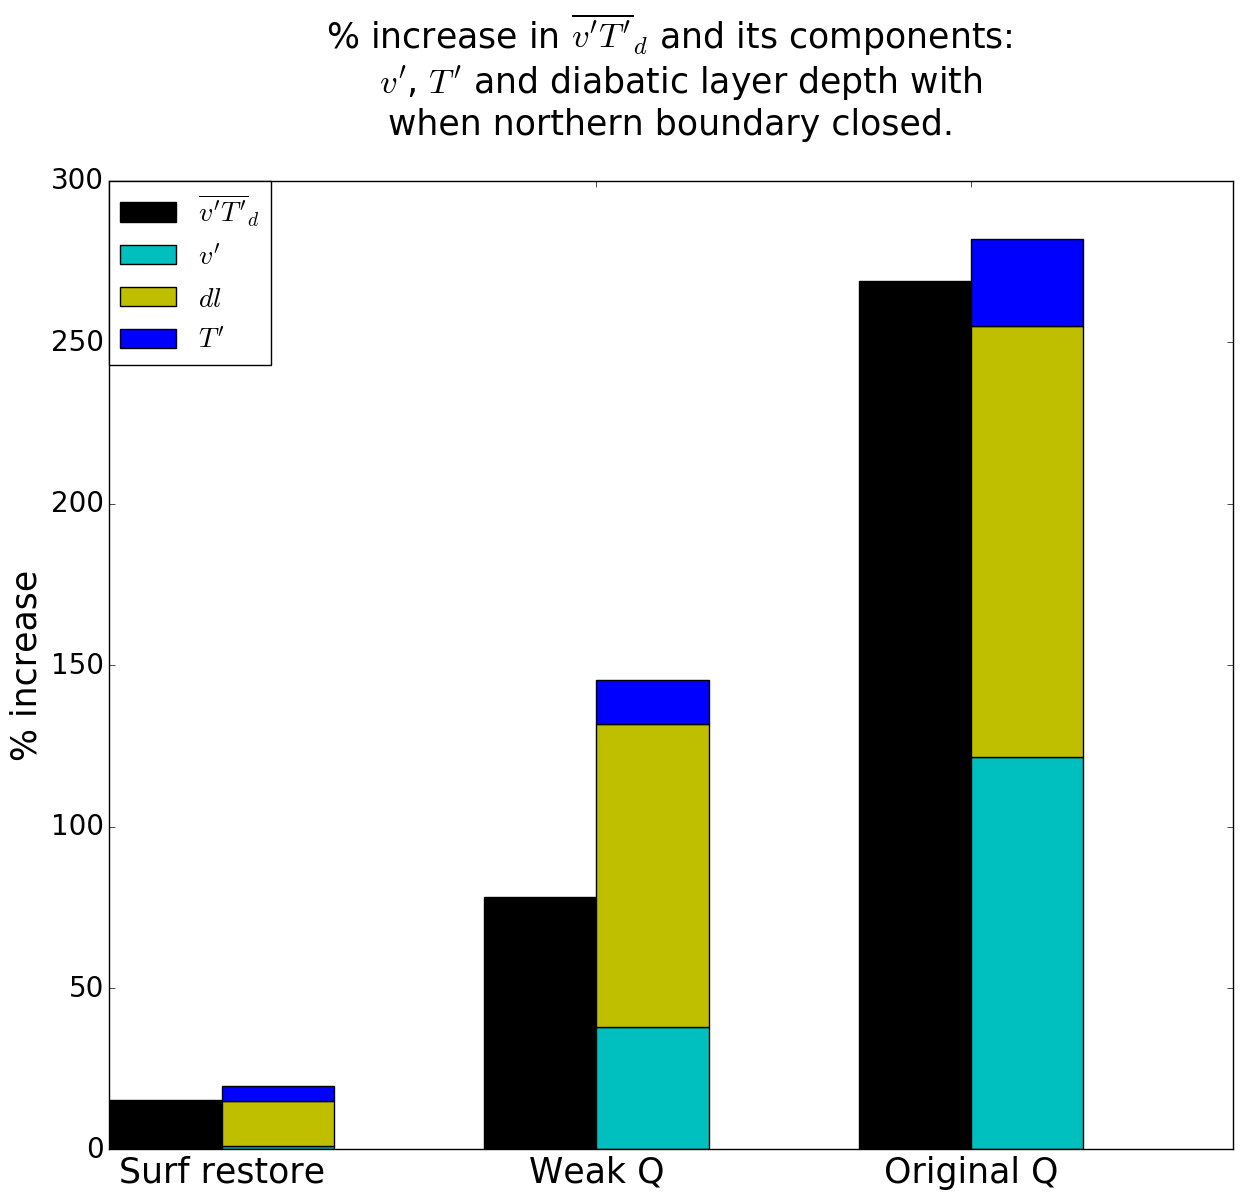

In [207]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = (1,2,3)
Tau2 =[1.3,2.3,3.3]
wdt = 0.5
p = plt.bar(Tau,Dsum2*100,color='k',width=.3)
p1 = plt.bar(Tau2,abs(Vsum2)*100, color='c',width=.3)
p2 = plt.bar(Tau2,abs(Darea2)*100 , color='y',width=.3,bottom=abs(Vsum2)*100)
p3 = plt.bar(Tau2,abs(APEt2)*100, color='b',width=.3,bottom=(abs(Vsum2)+abs(Darea2))*100)
#ylim(0,1.2)

xticks(Tau2,('Surf restore', 'Weak Q', 'Original Q'),fontsize=25)

yticks(fontsize=20)
xlabel('', fontsize=25)
ylabel(r'% increase', fontsize=25)
title("% increase in $\overline{v^\prime T ^\prime}_{d}$ and its components: \n  $v ^\prime$, $T ^\prime$ and diabatic layer depth with \n when northern boundary closed. \n",fontsize=25)
lgd = plt.legend([r'$\overline{v^\prime T ^\prime}_{d}$',r'$v ^\prime$',r'$dl$',r'$T ^\prime$',
                  'Q'], loc=2, borderaxespad=0.,fontsize=20)

In [185]:
Dsum2*100

array([  15.25459455,   78.20541036,  268.90635694])

In [203]:
(abs(Darea2)/Dsum2)*100#.mean()

array([  92.4097286 ,  120.07749427,   49.60046394])

In [209]:
((abs(Vsum2)/Dsum2))*100

array([  6.43561187,  48.55321505,  45.19600913])

In [202]:
(abs(APEt2)/Dsum2)*100

array([ 30.00407116,  17.16525858,  10.0004576 ])

In [205]:
abs(APEt2)*100

array([  4.57699941,  13.42416091,  26.89186622])

In [206]:
abs(Darea2)*100

array([  14.09672943,   93.90709715,  133.37880061])